In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

#import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as k

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, TensorBoard
from tensorflow.keras.utils import Sequence, plot_model

from IPython.display import Image

In [3]:
from root_pandas import read_root

Welcome to JupyROOT 6.18/04


In [4]:
fDataNameTrain = "./tmva/gun_k0L_allgev_FTFP_BERT_160000evt_ILD_l5_v02steel.root"
fTreeNameTrain = "tree"

#variables = (["energy", "eecal", "ehcal", "nhits", "nhits_ecal", "nhits_hcal"])
variables1 = (["n30", "n35", "n40", "n45", "n50", "n55", "n60", "n65", "n70", "n75", "n80", "nav", "c30", "c35", "c40", "c45", "c50", "c55", "c60", "c65", "c70", "c75", "c80", ])
variables2 = (["muon_energy", "muon_energy_hit", "muon_nhits", "muon_nhits_t", "muon_time", "muon_layer"])
target = "mc_energy"

variables = variables1 + variables2

def prepare_data(fName, treeName):
#    data = read_root(fName, treeName, columns=variablesLoad)
    data = read_root(fName, treeName)

    y = data[ target ].values
    
    for var in variables:
        data.drop(var, axis=1, inplace=True)
    X = data.values

    input_shape = X.shape[1:]

    #for i in range(input_shape[0]):
    #    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
    return data, X, y, input_shape

trainData, X_train, y_train, input_shape = prepare_data( fDataNameTrain, fTreeNameTrain)

In [5]:
#import pandas as pd
#import numpy as np

#rs = np.random.RandomState(0)
#df = pd.DataFrame(trainData)
#corr = df.corr()
#corr.style.background_gradient(cmap='coolwarm')


In [6]:
def loss(y_true, y_pred):
    return k.mean( k.square( (y_pred - y_true)/(y_true)  ) )  !!!!!!!!!!!!!!!!!!

In [7]:
a = Input(shape=input_shape)
b = Dense(30)(a)
b = Dropout(rate=0.5)(b)
b = Activation('sigmoid')(b)
b = Dense(20)(a)
b = Dropout(rate=0.5)(b)
b = Activation('sigmoid')(b)
c = Dense(1)(b)

model = Model(inputs = a, outputs = c)

optimizer = keras.optimizers.RMSprop(0.0099)
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss=loss, optimizer='adam')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


2020-02-29 01:32:35.855284: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-wn-4.0.5-1_umd4v1/lib64:/cvmfs/grid.cern.ch/centos7-wn-4.0.5-1_umd4v1/lib:/cvmfs/grid.cern.ch/centos7-wn-4.0.5-1_umd4v1/usr/lib64:/cvmfs/grid.cern.ch/centos7-wn-4.0.5-1_umd4v1/usr/lib:/cvmfs/grid.cern.ch/centos7-wn-4.0.5-1_umd4v1/usr/lib64/dcap
2020-02-29 01:32:35.855345: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2020-02-29 01:32:35.855380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1051.desy.de): /proc/driver/nvidia/version does not exist
2020-02-29 01:32:35.856385: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled

In [8]:
#testData, X_test, y_val3, input_shape3 = prepare_data(fDataNameTest, fTreeNameTest)


In [9]:
class Stopper(Callback):
    
    def __init__(self):
        self.s_min = 1
        self.n = 0
        
    def on_epoch_end(self, epoch, logs):
        y_pred = self.model.predict_on_batch(self.validation_data[0])[:,0]
        self.s = stats.ks_2samp(y_pred, self.validation_data[1][:,0]).statistic
        print(self.s)
        if self.s < self.s_min:
            self.s_min = self.s
            self.model.save('ANN.h5')
        if logs["val_loss"] > logs["loss"]:
            self.model.stop_training = True

In [10]:
stop = Stopper()
# checkpoint = ModelCheckpoint('ANNCorr.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, verbose=1)
# tb = TensorBoard(log_dir='./logs', histogram_freq=1)

history_train = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3, verbose=2, callbacks=[reduce_lr])
#history_test = model.fit(X_test, y_val3, epochs=100, batch_size=128, validation_split=0.3, verbose=2, callbacks=[reduce_lr])

Train on 97621 samples, validate on 41838 samples
Epoch 1/100
97621/97621 - 2s - loss: 0.0492 - val_loss: 2.0202e-04
Epoch 2/100
97621/97621 - 2s - loss: 0.0200 - val_loss: 2.0339e-04
Epoch 3/100
97621/97621 - 2s - loss: 0.0167 - val_loss: 2.0575e-04
Epoch 4/100

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
97621/97621 - 2s - loss: 0.0147 - val_loss: 2.0734e-04
Epoch 5/100
97621/97621 - 2s - loss: 0.0142 - val_loss: 2.0740e-04
Epoch 6/100
97621/97621 - 2s - loss: 0.0142 - val_loss: 2.0769e-04
Epoch 7/100

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001.
97621/97621 - 2s - loss: 0.0141 - val_loss: 2.0791e-04
Epoch 8/100
97621/97621 - 2s - loss: 0.0140 - val_loss: 2.0802e-04
Epoch 9/100
97621/97621 - 2s - loss: 0.0138 - val_loss: 2.0818e-04
Epoch 10/100
97621/97621 - 2s - loss: 0.0138 - val_loss: 2.0838e-04
Epoch 11/100
97621/97621 - 2s - loss: 0.0138 - val_loss: 2.0837e-04
Epoch 12/100
97621/97621 - 2s - loss: 0.0137 - val_loss: 2.0860

In [ ]:
model.save('ANN.h5')
model = load_model('ANN.h5')

In [12]:
def kss(y_true, y_pred):
    y1 = K.cast(tf.sort(y_true), dtype='float32')
    y2 = K.cast(tf.sort(y_pred), dtype='float32')
    n1 = K.cast(K.shape(y1), dtype='float32')
    n2 = K.cast(K.shape(y2), dtype='float32')
    y_all = K.concatenate([y1, y2])
    cdf1 = K.cast(tf.searchsorted(y1, y_all, side='right'), dtype='float32') / n1
    cdf2 = K.cast(tf.searchsorted(y2, y_all, side='right'), dtype='float32') / n2
    return K.max(K.abs(cdf1 - cdf2))

In [13]:
# a = Input(shape=input_shape)
# b = Dense(5, kernel_regularizer=regularizers.l2(0.01))(a)
# b = Activation('relu')(b)
# b = Dropout(rate=0.8)(b)
# b = Dense(10, kernel_regularizer=regularizers.l2(0.01))(b)
# b = Activation('relu')(b)
# b = Dropout(rate=0.8)(b)
# b = Dense(20, kernel_regularizer=regularizers.l2(0.01))(b)
# b = Activation('relu')(b)
# b = Dropout(rate=0.8)(b)
# b = Dense(10, kernel_regularizer=regularizers.l2(0.01))(b)
# b = Activation('relu')(b)
# b = Dropout(rate=0.8)(b)
# b = Dense(5, kernel_regularizer=regularizers.l2(0.01))(b)
# b = Activation('relu')(b)
# c = Dense(1)(a)

# model = Model(inputs = a, outputs = c)

# model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])

In [14]:
#import pydot
#from pydototprint import
#plot_model(model, to_file='model.png', show_shapes=True)
#Image('model.png')

In [15]:
history_train.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

In [16]:
history_test.history.keys()

NameError: name 'history_test' is not defined

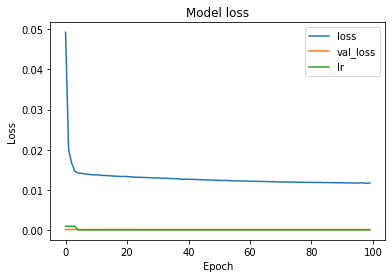

In [17]:
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.plot(history_train.history['lr'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss', 'lr'], loc='upper right')
plt.show()

In [18]:
model.predict( [ 45 ] )

ValueError: Error when checking input: expected input_1 to have shape (64,) but got array with shape (1,)

In [19]:
test = read_root("./data/gun_k0L_5gev_FTFP_BERT_5000evt_ILD_l5_v02steel.root", "tree")

In [20]:
variables_test = (["n30", "n35", "n40", "n45", "n50", "n55", "n60", "n65", "n70", "n75", "n80", "nav", "c30", "c35", "c40", "c45", "c50", "c55", "c60", "c65", "c70", "c75", "c80", ])


In [21]:
aaa = ["energy", "eecal", "ehcal", ]

In [22]:
xtest = test[ aaa ].values

In [23]:
model.predict( X_train )

array([[1.4451466],
       [1.3157029],
       [1.7614647],
       ...,
       [2.0988173],
       [2.0988173],
       [2.0988173]], dtype=float32)